In [34]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label

In [35]:
# Create a random segmentation dataset
np.random.seed(42)

# Generate synthetic segmentation data (binary masks)
n_samples = 100
image_size = (64, 64)

# Generate random binary masks (ground truth)
y_true_list = []
for i in range(n_samples):
    # Create random shapes in the mask
    mask = np.zeros(image_size)
    n_objects = np.random.randint(1, 4)
    for _ in range(n_objects):
        center_x = np.random.randint(10, image_size[0]-10)
        center_y = np.random.randint(10, image_size[1]-10)
        radius = np.random.randint(5, 15)
        y, x = np.ogrid[:image_size[0], :image_size[1]]
        mask_circle = (x - center_x)**2 + (y - center_y)**2 <= radius**2
        mask[mask_circle] = 1
    y_true_list.append(mask)

y_true = np.array(y_true_list)

print(f"Dataset shape: {y_true.shape}")

Dataset shape: (100, 64, 64)


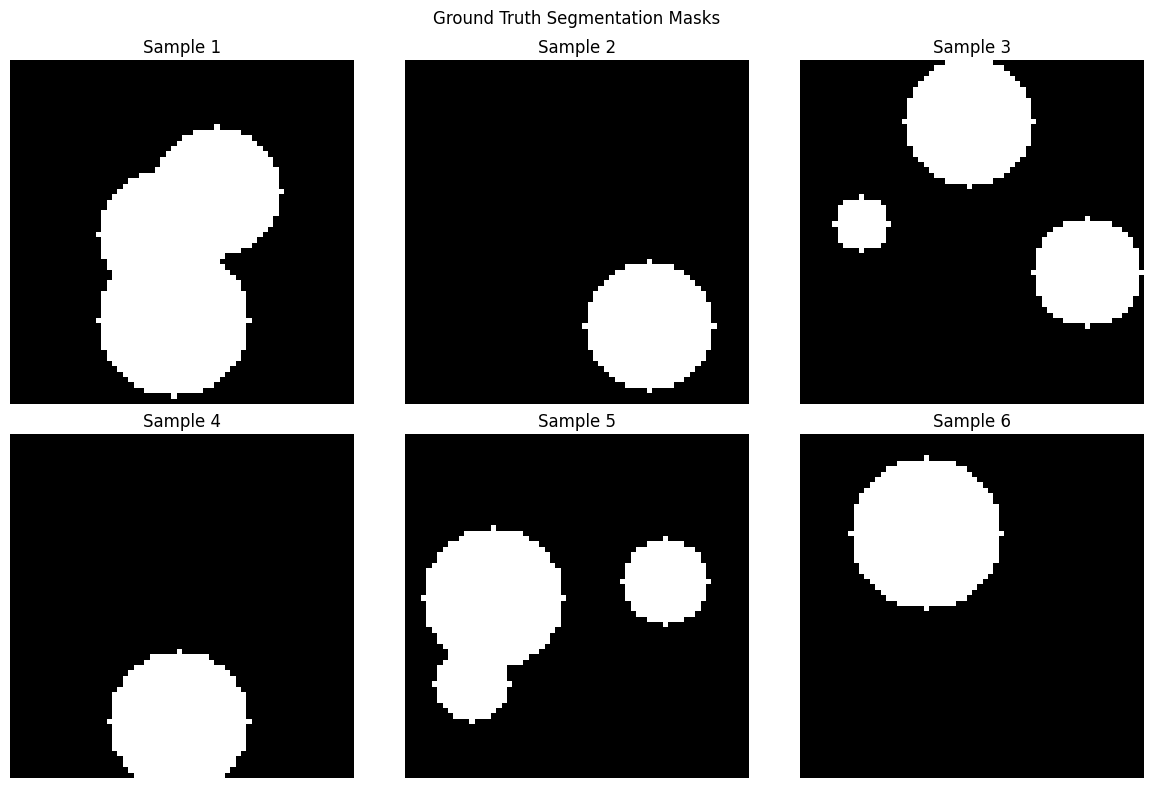

In [36]:
# Visualize a few examples from the dataset
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(y_true[i], cmap='gray')
    ax.set_title(f'Sample {i+1}')
    ax.axis('off')
plt.suptitle('Ground Truth Segmentation Masks')
plt.tight_layout()
plt.show()

In [37]:
# Split the dataset into training and testing sets
y_train, y_test = train_test_split(y_true, test_size=0.3, random_state=42)

print(f"Training set size: {y_train.shape[0]}")
print(f"Testing set size: {y_test.shape[0]}")

Training set size: 70
Testing set size: 30


In [38]:
# Simulate predictions with some noise
# In real scenario, this would be model.predict(X_test)
y_pred = []
for mask in y_test:
    # Add noise to simulate prediction errors
    pred = mask.copy()
    # Randomly flip some pixels to simulate imperfect predictions
    noise = np.random.random(mask.shape) < 0.02  # 2% noise
    pred[noise] = 1 - pred[noise]
    y_pred.append(pred)

y_pred = np.array(y_pred)

In [39]:
# Define segmentation metrics functions using libraries

def calculate_iou(y_true, y_pred):
    """Calculate Intersection over Union (IoU) using sklearn"""
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return jaccard_score(y_true_flat, y_pred_flat, average='binary', zero_division=1.0)

def calculate_dice_score(y_true, y_pred):
    """Calculate Dice Score (F1 Score for segmentation)"""
    intersection = np.logical_and(y_true, y_pred).sum()
    if y_true.sum() + y_pred.sum() == 0:
        return 1.0  # Both masks are empty
    return 2 * intersection / (y_true.sum() + y_pred.sum())

def calculate_pixel_accuracy(y_true, y_pred):
    """Calculate Pixel Accuracy using sklearn"""
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return accuracy_score(y_true_flat, y_pred_flat)

def calculate_mean_iou(y_true_batch, y_pred_batch, num_classes=2):
    """Calculate Mean IoU across all samples and classes"""
    iou_per_class = []
    for class_id in range(num_classes):
        y_true_class = (y_true_batch == class_id).astype(int).flatten()
        y_pred_class = (y_pred_batch == class_id).astype(int).flatten()
        
        iou = jaccard_score(y_true_class, y_pred_class, average='binary', zero_division=1.0)
        iou_per_class.append(iou)
    
    return np.mean(iou_per_class)

In [40]:
# Calculate metrics for each sample
iou_scores = []
dice_scores = []
pixel_accuracies = []

for i in range(len(y_test)):
    iou = calculate_iou(y_test[i], y_pred[i])
    dice = calculate_dice_score(y_test[i], y_pred[i])
    pixel_acc = calculate_pixel_accuracy(y_test[i], y_pred[i])
    
    iou_scores.append(iou)
    dice_scores.append(dice)
    pixel_accuracies.append(pixel_acc)

# Calculate mean IoU across all samples and classes
mean_iou = calculate_mean_iou(y_test, y_pred, num_classes=2)

# Calculate average metrics
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)
avg_pixel_acc = np.mean(pixel_accuracies)

print("Segmentation Metrics:")
print(f"IoU (Intersection over Union): {avg_iou:.4f}")
print(f"Dice Score:                    {avg_dice:.4f}")
print(f"Pixel Accuracy:                {avg_pixel_acc:.4f}")
print(f"Mean IoU (all classes):        {mean_iou:.4f}")

Segmentation Metrics:
IoU (Intersection over Union): 0.8182
Dice Score:                    0.8938
Pixel Accuracy:                0.9797
Mean IoU (all classes):        0.9247


In [41]:
# Create a summary DataFrame
metrics_df = pd.DataFrame({
    'IoU': iou_scores,
    'Dice Score': dice_scores,
    'Pixel Accuracy': pixel_accuracies
})

print("Metrics Statistics:")
print(metrics_df.describe())

Metrics Statistics:
             IoU  Dice Score  Pixel Accuracy
count  30.000000   30.000000       30.000000
mean    0.818199    0.893832        0.979688
std     0.130416    0.089392        0.002441
min     0.469880    0.639344        0.975586
25%     0.782348    0.877855        0.978333
50%     0.861453    0.925563        0.979004
75%     0.908502    0.952057        0.981140
max     0.946357    0.972439        0.985107


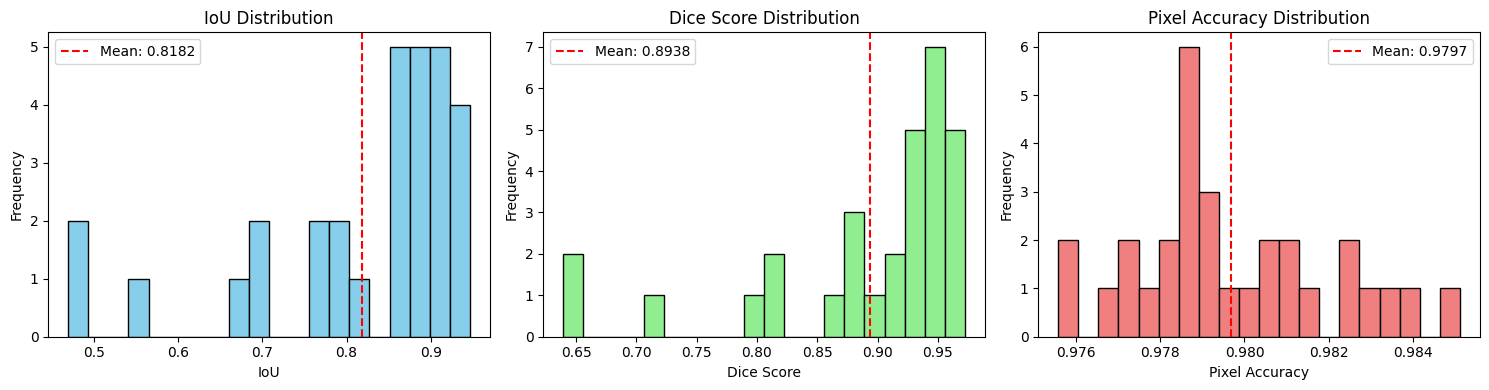

In [42]:
# Visualize metrics distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(iou_scores, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('IoU Distribution')
axes[0].set_xlabel('IoU')
axes[0].set_ylabel('Frequency')
axes[0].axvline(avg_iou, color='red', linestyle='--', label=f'Mean: {avg_iou:.4f}')
axes[0].legend()

axes[1].hist(dice_scores, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Dice Score Distribution')
axes[1].set_xlabel('Dice Score')
axes[1].set_ylabel('Frequency')
axes[1].axvline(avg_dice, color='red', linestyle='--', label=f'Mean: {avg_dice:.4f}')
axes[1].legend()

axes[2].hist(pixel_accuracies, bins=20, color='lightcoral', edgecolor='black')
axes[2].set_title('Pixel Accuracy Distribution')
axes[2].set_xlabel('Pixel Accuracy')
axes[2].set_ylabel('Frequency')
axes[2].axvline(avg_pixel_acc, color='red', linestyle='--', label=f'Mean: {avg_pixel_acc:.4f}')
axes[2].legend()

plt.tight_layout()
plt.show()

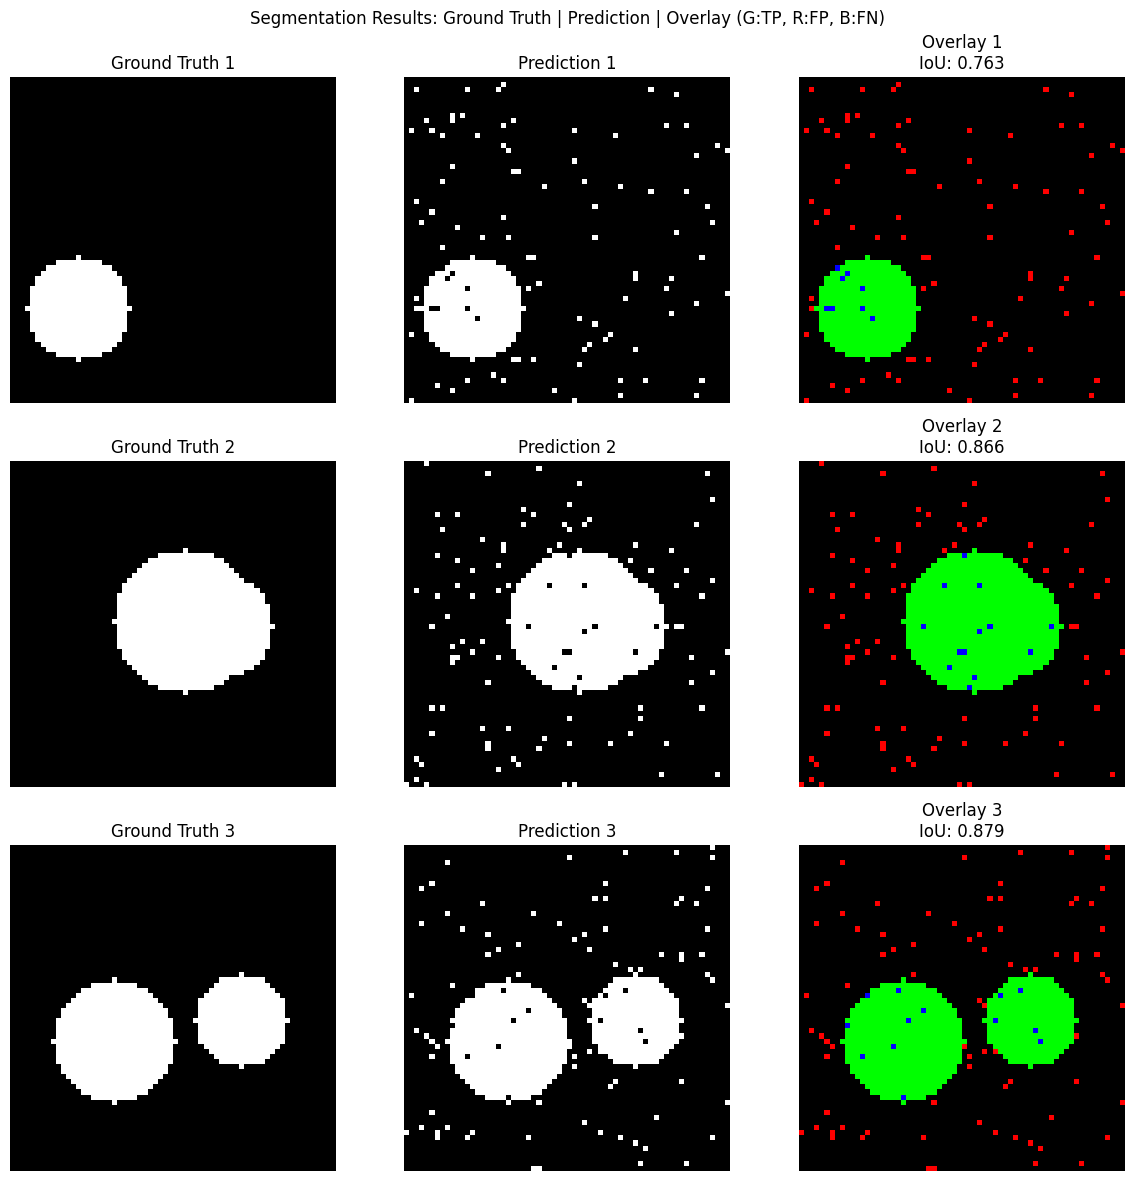

In [43]:
# Visualize predictions vs ground truth for a few samples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    # Ground truth
    axes[i, 0].imshow(y_test[i], cmap='gray')
    axes[i, 0].set_title(f'Ground Truth {i+1}')
    axes[i, 0].axis('off')
    
    # Prediction
    axes[i, 1].imshow(y_pred[i], cmap='gray')
    axes[i, 1].set_title(f'Prediction {i+1}')
    axes[i, 1].axis('off')
    
    # Overlay (Green: TP, Red: FP, Blue: FN)
    overlay = np.zeros((*y_test[i].shape, 3))
    tp = np.logical_and(y_test[i], y_pred[i])
    fp = np.logical_and(~y_test[i].astype(bool), y_pred[i])
    fn = np.logical_and(y_test[i], ~y_pred[i].astype(bool))
    
    overlay[tp, 1] = 1  # Green for True Positives
    overlay[fp, 0] = 1  # Red for False Positives
    overlay[fn, 2] = 1  # Blue for False Negatives
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}\nIoU: {iou_scores[i]:.3f}')
    axes[i, 2].axis('off')

plt.suptitle('Segmentation Results: Ground Truth | Prediction | Overlay (G:TP, R:FP, B:FN)', fontsize=12)
plt.tight_layout()
plt.show()

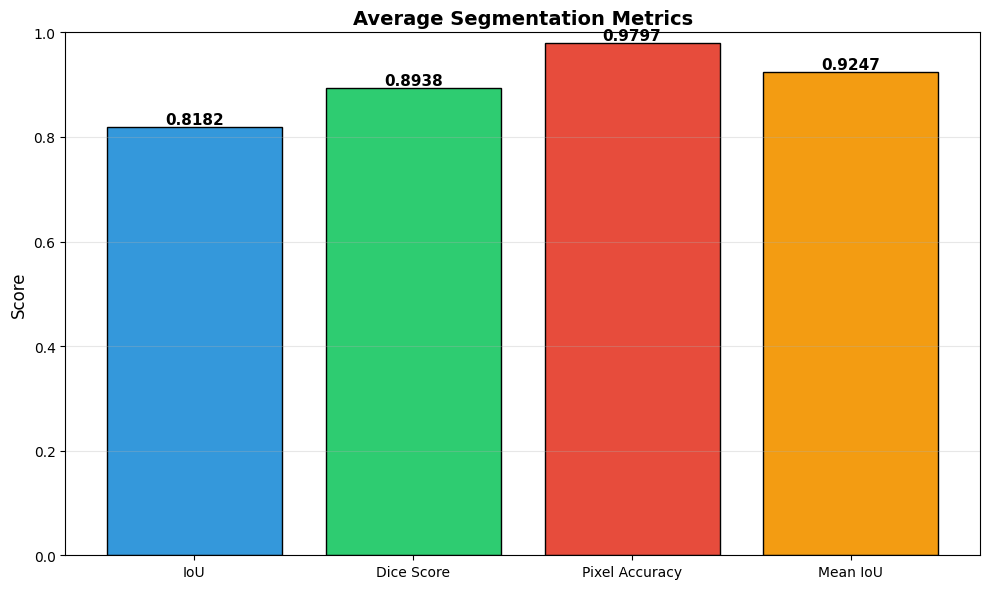

In [44]:
# Create a bar plot for average metrics
metrics_names = ['IoU', 'Dice Score', 'Pixel Accuracy', 'Mean IoU']
metrics_values = [avg_iou, avg_dice, avg_pixel_acc, mean_iou]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'], edgecolor='black')
plt.ylabel('Score', fontsize=12)
plt.title('Average Segmentation Metrics', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()